# Dashboard with Recommendation

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from datetime import datetime
from datetime import timedelta
import re
from dateutil.parser import parse
import string
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans

import ipywidgets

from csaps import csaps

import imageio
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

from statsmodels.nonparametric.smoothers_lowess import lowess

from scipy.spatial.transform import Rotation as R
from scipy.spatial import distance
import pickle
pd.set_option('display.max_columns', None)

# Data Loading

In [4]:
# read
tags=pd.read_excel("../../data/meta data/tags_relevantes.xlsx")
tags_cc=tags.tag.to_list()
dic={}
for i,j in zip(tags.tag,tags.description):
    dic[i]=j
tags

,tag,description,upper bound,lower bound,unit
0,CF:CVB007_S2.PNT.FOX,granulometry,NaN,NaN,NaN
1,CF:225.WIC8067.MEAS.FOX,charge cell,NaN,NaN,NaN
2,disp_ley_pirita,pyrite law,NaN,NaN,NaN
3,disp_ley_calcopirita,chalcopyrite law,NaN,NaN,NaN
4,disp_ley_calcosina,chalcocite law,NaN,NaN,NaN
5,disp_crusher_index,crusher index,NaN,NaN,NaN
6,disp_sag_power_index,sag power index,NaN,NaN,NaN
7,disp_ball_work_index,ball work index,NaN,NaN,NaN
8,CF:215.WIC1605A.MEAS.FOX,TPH,NaN,NaN,NaN
9,CF:EXPERTO:EXP_MS_A.MEAS_5.FOX,HH TPH,NaN,NaN,NaN


In [5]:
Z=pd.read_csv("../../data/raw data/raw_data_base_model.csv")
Z.sort_index(inplace=True)
Z.rename(columns=dic,inplace=True)
Z["edad_sag"]=Z["edad_sag"]-1
Z["cat_small"]=Z["edad_sag"].astype(int).astype(str)+Z["cluster"].astype(str)
Z.head()

,Time 1,TPH,charge cell,granulometry,States,edad_sag,solid percentage,water,speed,crusher index,sag power index,ball work index,chalcopyrite law,pyrite law,chalcocite law,bornite law,covelin law,cluster,cat_small
0,2019-01-01 08:00:00,4018.818142,843.684110,64.022592,D,1.0,70.246111,1704.887646,8.749765,19.6951,143.2197,17.3164,1.14,2.58,0.78,0.0,0.02,3,13
1,2019-01-01 08:01:00,3976.789547,838.006287,63.920672,D,1.0,70.034488,1700.394278,8.750025,19.6951,143.2197,17.3164,1.14,2.58,0.78,0.0,0.02,3,13
2,2019-01-01 08:02:00,4047.005457,830.411897,63.789870,D,1.0,70.223170,1720.531756,8.749208,19.6951,143.2197,17.3164,1.14,2.58,0.78,0.0,0.02,3,13
3,2019-01-01 08:03:00,4072.856177,825.028150,63.983669,D,1.0,70.183939,1732.043406,8.749556,19.6951,143.2197,17.3164,1.14,2.58,0.78,0.0,0.02,3,13
4,2019-01-01 08:04:00,4118.992273,819.513324,64.460974,E,1.0,70.207796,1749.908282,8.749200,19.6951,143.2197,17.3164,1.14,2.58,0.78,0.0,0.02,3,13


In [6]:
Z.shape

(634918, 19)

In [7]:
Z["edad_sag"].unique()

array([1., 2., 0.])

In [8]:
Z["cat_small"].unique()

array(['13', '11', '10', '12', '22', '23', '20', '21', '03', '00', '02',
       '01'], dtype=object)

In [9]:
input_col=['CF:CVB007_S2.PNT.FOX','edad_sag','disp_crusher_index','disp_sag_power_index',
         'disp_ball_work_index', 'disp_ley_calcopirita','disp_ley_pirita', 'disp_ley_calcosina',
          'disp_ley_bornita','disp_ley_covelina']

input_col=list(pd.DataFrame({"lista":input_col}).replace(dic)["lista"])
input_col

['granulometry',
 'edad_sag',
 'crusher index',
 'sag power index',
 'ball work index',
 'chalcopyrite law',
 'pyrite law',
 'chalcocite law',
 'bornite law',
 'covelin law']

# Dispatch Cluster object.

The variable `n` sets the number of clusters. We are using `n=4`. Please be aware that for larger n the population of the states gets reduced, and the code might not run until the end.

In [11]:
%%time
n=4
kmeans = KMeans(n_clusters=n, random_state=1982).fit(Z[input_col[2:]].drop_duplicates()) 
Z['cluster']=kmeans.predict(Z[input_col[2:]])

pickle.dump(kmeans, open('../../models/Clasificador_dispatch_n_4.pkl', 'wb'))

Wall time: 982 ms


# Interactive Widget to explore the raw data.

In [12]:
gran = ipywidgets.widgets.BoundedIntText(
    value=50,
    min=Z['granulometry'].min(),
    max=Z['granulometry'].max(),
    step=1,
    description='Granulometría:',
    disabled=False,
    style={'description_width': 'initial'}
)

rango = ipywidgets.FloatSlider(
    value=1,
    min=0,
    max=10.0,
    step=0.5,
    description='Rango:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
    style={'description_width': 'initial'}
)

cat = ipywidgets.Dropdown(
    options=list(Z['cat_small'].value_counts().index),
    value=Z['cat_small'].value_counts().index[1],
    description='Sub-Contexto:',
    disabled=False,
    style={'description_width': 'initial'}
)








def create_scatter(cat, gran, rango):
    fig = plt.figure(figsize=(14,4))
    ax1 = fig.add_subplot(121)

    
    tmp=Z[(Z['cat_small']==cat)&(Z['granulometry']>gran-rango)&(Z['granulometry']<gran+rango)]
    tmp1=Z[(Z['cat_small']==cat)]

    
    plt.scatter(x=tmp[tmp['States']=='D']['charge cell'], 
                y=tmp[tmp['States']=='D']['TPH'], color='blue', alpha=0.6)
    plt.scatter(x=tmp[tmp['States']=='E']['charge cell'], 
                y=tmp[tmp['States']=='E']['TPH'], color='blue', alpha=0.6)
    plt.scatter(x=tmp[tmp['States']=='A']['charge cell'], 
                y=tmp[tmp['States']=='A']['TPH'], color='blue', alpha=0.6)

    plt.ylim([tmp1['TPH'].min(),tmp1['TPH'].max()+100])
    plt.xlim([tmp1['charge cell'].min(),tmp1['charge cell'].max()+50])
    plt.xlabel('Charge Cell')
    plt.ylabel('TPH')
    
    
    
    
    ax2 = fig.add_subplot(122)
    d=Z[(Z['cat_small']==cat)][input_col[1:]].rename(columns={'edad_sag':'SAG',
                        'disp_crusher_index':'Crusher ind',
                        'disp_sag_power_index':'SPI',
                        'disp_ball_work_index':'BWI',
                        'disp_ley_calcopirita':'Calcopirita',
                        'disp_ley_pirita':'Pirita',
                        'disp_ley_calcosina':'Calcosina',
                        'disp_ley_bornita':'Bornita',
                        'disp_ley_covelina':'Covelina'}).describe().T[['mean', 'std']].round(2)
    #font_size = 10
    bbox = [0.3, 0, 0.7, 1]
    ax2.axis('off')
    mpl_table = ax2.table(cellText=d.values, rowLabels=d.index, bbox=bbox, colLabels=d.columns, colWidths=[0.3,0.3,0.6])
    mpl_table.set_fontsize(10)


ipywidgets.interact(create_scatter, cat=cat, rango=rango, gran=gran);

interactive(children=(Dropdown(description='Sub-Contexto:', index=1, options=('20', '00', '10', '12', '13', '0…

In this widget we can explore the raw data. In the right pannel, we can see the details of the sub-context. On the top you can select a sub-context, where the first number corresponds to the age of the SAG Mill liners being:

- 0: New
- 1: Medium
- 2: Old

As a reminder, each age last for two months.

The next widget you can select the granulometry, and vary it. In Rango you can select the range of the granulometry that you want to see, centered on the previous value, e.g., 50 plus minus 1 or 2, etc.

The graph corresponds to a curve of TPH vs Charge Cell, and the plots are minute data. The colors corresponds to the type of state, where:

- Red : Crossover state between Limited by TPH and Limited by Charge cell.
- Yellow or Orange : Limited by TPH.
- Blue : Limited by Charge Cell.

This is the limited information that we have for the grindability curve for these contexts. Now we need to extract the top shape of this cloud, and use that curve to detect when it starts to decrease, and that is our recommendation.


### 6) Create dictionary with all the images.

Please run this next cell, where all the info of the plots will be saved in a dictionary, for later visualuzation.

In [11]:
tags

,tag,description,upper bound,lower bound,unit
0,CF:CVB007_S2.PNT.FOX,granulometry,NaN,NaN,NaN
1,CF:225.WIC8067.MEAS.FOX,charge cell,NaN,NaN,NaN
2,disp_ley_pirita,pyrite law,NaN,NaN,NaN
3,disp_ley_calcopirita,chalcopyrite law,NaN,NaN,NaN
4,disp_ley_calcosina,chalcocite law,NaN,NaN,NaN
5,disp_crusher_index,crusher index,NaN,NaN,NaN
6,disp_sag_power_index,sag power index,NaN,NaN,NaN
7,disp_ball_work_index,ball work index,NaN,NaN,NaN
8,CF:215.WIC1605A.MEAS.FOX,TPH,NaN,NaN,NaN
9,CF:EXPERTO:EXP_MS_A.MEAS_5.FOX,HH TPH,NaN,NaN,NaN


In [13]:
%%time
dic_images={}

rango=1

for cat in Z['cat_small'].value_counts().index:
    
    G=np.arange(np.ceil(Z[(Z['cat_small']==cat)]['granulometry'].min()),np.ceil(Z[(Z['cat_small']==cat)]['granulometry'].max()))
    
    #Generar lista con granulometrias, usaremos el rango pedido, y con los valores enteros.
    
    dicg={}
    
    for g in G:
    
        fig = plt.figure(figsize=(14,4))
        ax1 = fig.add_subplot(121)


        tmp=Z[(Z['cat_small']==cat)&(Z['granulometry']>g-rango)&(Z['granulometry']<g+rango)]
        tmp1=Z[(Z['cat_small']==cat)]


        plt.scatter(x=tmp[tmp['States']=='D']['charge cell'], 
                    y=tmp[tmp['States']=='D']['TPH'], color='blue', alpha=0.6)
        plt.scatter(x=tmp[tmp['States']=='E']['charge cell'], 
                    y=tmp[tmp['States']=='E']['TPH'], color='blue', alpha=0.6)
        plt.scatter(x=tmp[tmp['States']=='A']['charge cell'], 
                    y=tmp[tmp['States']=='A']['TPH'], color='blue', alpha=0.6)

        plt.ylim([tmp1['TPH'].min(),tmp1['TPH'].max()+100])
        plt.xlim([tmp1['charge cell'].min(),tmp1['charge cell'].max()+50])
        plt.xlabel('Charge Cell')
        plt.ylabel('TPH')
        plt.title('Categoría '+cat+' Granulometría '+str(g))



        ax2 = fig.add_subplot(122)
        d=Z[(Z['cat_small']==cat)][input_col[1:]].rename(columns={'edad_sag':'SAG',
                            'disp_crusher_index':'Crusher ind',
                            'disp_sag_power_index':'SPI',
                            'disp_ball_work_index':'BWI',
                            'disp_ley_calcopirita':'Calcopirita',
                            'disp_ley_pirita':'Pirita',
                            'disp_ley_calcosina':'Calcosina',
                            'disp_ley_bornita':'Bornita',
                            'disp_ley_covelina':'Covelina'}).describe().T[['mean', 'std']].round(2)
        #font_size = 10
        bbox = [0.3, 0, 0.7, 1]
        ax2.axis('off')
        mpl_table = ax2.table(cellText=d.values, rowLabels=d.index, bbox=bbox, colLabels=d.columns, colWidths=[0.3,0.3,0.6])
        mpl_table.set_fontsize(10)
        dicg[g]=fig
        plt.close()


    dic_images[cat]=dicg


Wall time: 2min 59s


# Create Gif from previous dictionary.

In [14]:
import imageio
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

In [16]:
%%time
IMAGE=[]
for cat in dic_images.keys():
    image=[]
    for fig in dic_images[cat].values():
        canvas = FigureCanvas(fig)
        canvas.draw()
        width, height = fig.get_size_inches()*fig.get_dpi()
        img = np.fromstring(canvas.tostring_rgb(), dtype='uint8').reshape(int(height), int(width), 3)
        image.append(img)
        IMAGE.append(img)
    imageio.mimsave('../../data/meta data/cat_'+cat+'.gif',image)
imageio.mimsave('../../data/meta data/ALL_Categories.gif',IMAGE)

Wall time: 2min 26s


With this code, you can create a gif for all the data. It is quite interesting to obvserve the changes for a given sub-context, as a trend in the maximum charge cell with stable tph is clear.

### 8) Extract top of grindability curve.

This next cell extracts the top of each grindability curve, from which the recommendation will be obtained later.

The dictionaries have the following info:

- dic2: All the data with scaled TPH for the sub-context in the form of a pandas dataframe with charge cell, tph_scaled and granulometry
- dic3: The recommendation for a sub context vs the granulometry.

In [20]:
%%time
dic2={}
dic3={}

for cat in Z['cat_small'].value_counts().index:

    rango=1
    G=np.arange(np.ceil(Z[(Z['cat_small']==cat)]['granulometry'].min()),np.ceil(Z[(Z['cat_small']==cat)]['granulometry'].max()))

    data=pd.DataFrame({'cc':np.nan, 'tph_scaled':np.nan, 'gran':np.nan}, index=[0])
    data2=pd.DataFrame({'cc':np.nan, 'gran':np.nan}, index=[0])
    for gran in G[4:-4]:


        tmp1=Z[(Z['cat_small']==cat)&(Z['granulometry']>gran-rango)&(Z['granulometry']<gran+rango)&
               ((Z['States']=='D')|(Z['States']=='E')|(Z['States']=='A'))
               ][['charge cell','TPH']]

        #Hay que extraer los puntos sueltos locos nomas, no tenemos otra. No podemos sacarnos la limpieza de datos.

        f1=0.5

        t=tmp1[(tmp1['charge cell']>tmp1['charge cell'].quantile(f1))&
              (tmp1['TPH']>tmp1['TPH'].quantile(f1))].apply(lambda x: (np.sqrt( (tmp1[tmp1['charge cell']>
                    tmp1['charge cell'].quantile(f1)]['charge cell']-x[0])**2 +
                    (tmp1[tmp1['charge cell']>
                    tmp1['charge cell'].quantile(f1)]['TPH']-x[1])**2/10000
                              )).mean(), axis=1)

        idx=(t.sort_values()-t.sort_values().shift(1)).replace(np.nan, 0).idxmax()
        tmp1.drop((t<t.sort_values().loc[idx]).replace(True,np.nan).dropna().index, inplace=True)


        df_test=tmp1.round(5)

        l9=pd.concat([df_test['TPH'],pd.cut(df_test['charge cell'],
            bins=np.linspace(Z[(Z['cat_small']==cat)]['charge cell'].min(),Z[(Z['cat_small']==cat)]['charge cell'].max(), 200),
                                                              precision=40).rename('C')],
        axis=1).groupby(['C']).quantile(0.95)

        l8=pd.concat([df_test['TPH'],pd.cut(df_test['charge cell'],
            bins=np.linspace(Z[(Z['cat_small']==cat)]['charge cell'].min(),Z[(Z['cat_small']==cat)]['charge cell'].max(), 200),
                                                              precision=40).rename('C')],
        axis=1).groupby(['C']).quantile(0.85)


        test=pd.Series([(x[0]+y[0])*0.5 for x,y in zip(l9.values,l8.values)],index=[(i.left+i.right)*0.5 for i in l9.index])

        tph_min=Z[(Z['cat_small']==cat)]['TPH'].min()

        #test.loc[:test.dropna().index[0]].iloc[:-1]=test.max()

        test[:tmp1['charge cell'].quantile(0.3)]=test.max()

        test.loc[test.dropna().index[-1]:].iloc[1:]=tph_min

        test.dropna(inplace=True)

        cs=csaps(test.index, test.values, smooth=0.05)

        test.loc[:pd.Series(cs(test[tmp1['charge cell'].quantile(0.4):].index), index=test[tmp1['charge cell'].quantile(0.4):].index).idxmax()]=pd.Series(cs(test[tmp1['charge cell'].quantile(0.4):].index), index=test[tmp1['charge cell'].quantile(0.4):].index).max()
        test[pd.Series(cs(test[tmp1['charge cell'].quantile(0.4):].index), index=test[tmp1['charge cell'].quantile(0.4):].index).idxmax():]=cs(test[pd.Series(cs(test[tmp1['charge cell'].quantile(0.4):].index), index=test[tmp1['charge cell'].quantile(0.4):].index).idxmax():].index)

        #Aca hay que poner el smoothing y lo de la convolución, y guardarlo de manera apropiada.
        
        step = np.hstack((np.ones(len(test)), -1*np.ones(len(test))))
        filtered = lowess(test.values, test.index, is_sorted=True, frac=0.1, it=0)
        test2 = pd.Series([x[1] for x in filtered], index=test.index)
        resto=test2.max()*0.95
        cc_max=pd.Series(pd.Series(np.convolve((test2-resto), step), index=np.arange(len(np.convolve(test2, step))))[:len(test2)].values,
          index=test2.index).idxmax()
        
        data2=pd.concat([data2,
                        pd.DataFrame({'cc':cc_max, 'gran':gran}, index=[0])]).dropna().reset_index(drop=True)
        
        test=test/max(cs(test[tmp1['charge cell'].quantile(0.4):].index))


        data=pd.concat([data,
            pd.DataFrame({'cc':test.index, 'tph_scaled':test.values, 'gran':gran})]).dropna().reset_index(drop=True)
    
    

    #    test.loc[:pd.Series(cs(test[tmp1['charge cell'].quantile(0.4):].index), index=test[tmp1['charge cell'].quantile(0.4):].index).idxmax()]=pd.Series(cs(test[tmp1['charge cell'].quantile(0.4):].index), index=test[tmp1['charge cell'].quantile(0.4):].index).max()
    #    test[pd.Series(cs(test[tmp1['charge cell'].quantile(0.4):].index), index=test[tmp1['charge cell'].quantile(0.4):].index).idxmax():]=cs(test[pd.Series(cs(test[tmp1['charge cell'].quantile(0.4):].index), index=test[tmp1['charge cell'].quantile(0.4):].index).idxmax():].index)

    #    plt.plot(test.index, test.values, color='blue', lw=3)

        #plt.close()
        #dic_08.append(fig)
    print(cat)
        
    dic2[cat]=data 
    dic3[cat]=data2

20
00
10
12
13
03
23
02
22
11
21
01
Wall time: 21min 47s


20


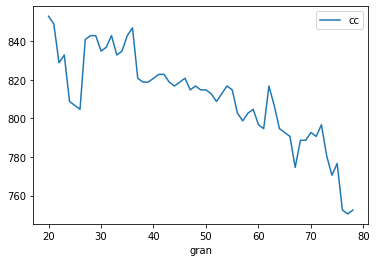

00


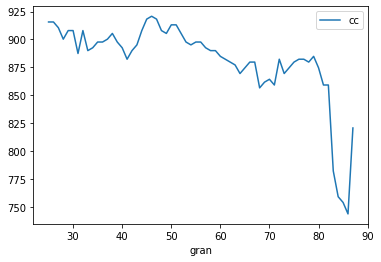

10


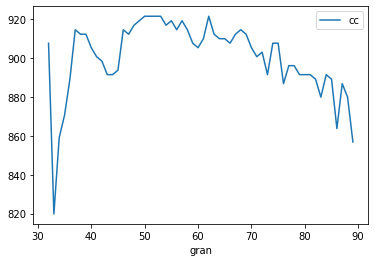

12


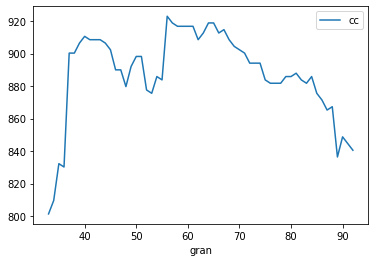

13


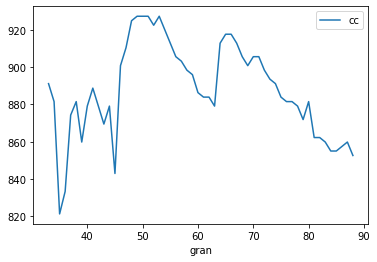

03


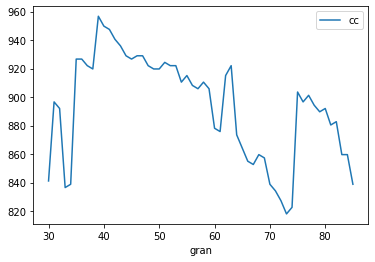

23


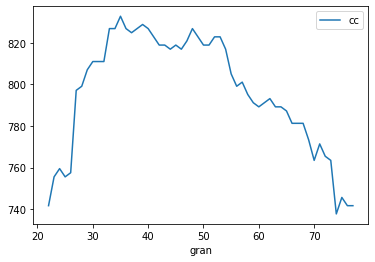

02


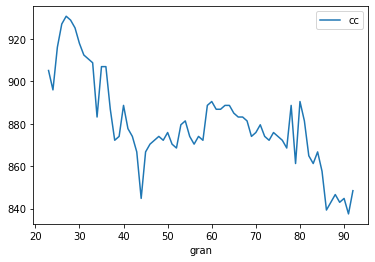

22


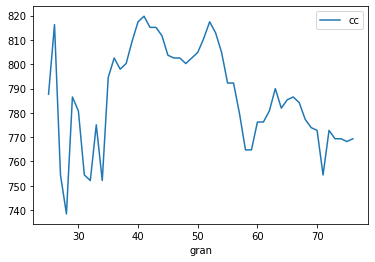

11


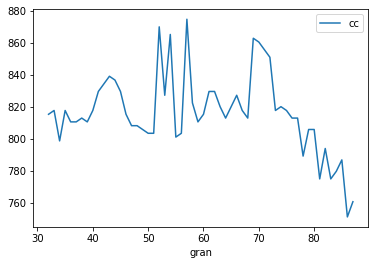

21


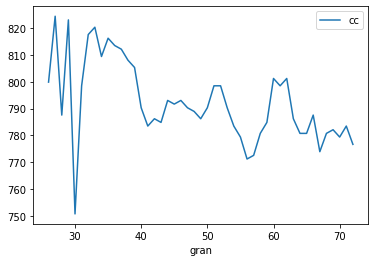

01


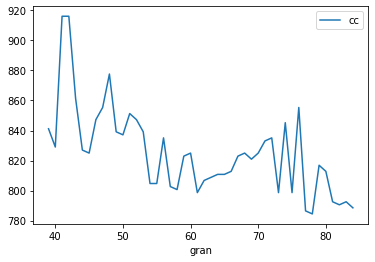

In [21]:
for i in dic3.keys():
    print(i)
    dic3[i].set_index('gran').plot()
    plt.show()

With the following cell you can save the dictionary of curves as a pickle object.

In [23]:
pickle.dump(dic3, open('../../models/Curvas de celda de carga vs granulometria actualizado.pkl', 'wb'))

### 9) Final Dashboard

In [65]:
cat = ipywidgets.Dropdown(
    options=list(Z['cat_small'].value_counts().index),
    value=Z['cat_small'].value_counts().index[1],
    description='Sub-Contexto:',
    disabled=False,
    style={'description_width': 'initial'}

)

gran = ipywidgets.widgets.BoundedIntText(
    value=50,
    min=Z['granulometry'].min(),
    max=Z['granulometry'].max(),
    step=1,
    description='Granulometría:',
    disabled=False,
    style={'description_width': 'initial'}
)




def create_scatter(cat, gran):
    fig = plt.figure(figsize=(14,8))
    ax1 = fig.add_subplot(221)
    data=dic2[cat]
    

    #plt.scatter(y=tmp['cc'], x=tmp['gran'], color='black')

    plt.ylim([data['cc'].quantile(0.5),data['cc'].max()])
    plt.xlim([data['gran'].min(),data['gran'].max()])
    plt.axvline(x=gran, lw=3, color='red')
    dic3[cat].set_index('gran').plot(ax=ax1, color='green', lw=4)
    plt.ylabel('Charge Cell')
    plt.xlabel('Granulometry')
    plt.title('Sub Context '+cat)
    
    test=dic3[cat].set_index('cc')
    filtered = lowess( test.index,[x[0] for x in test.values], is_sorted=True, frac=0.3, it=0)

    #pd.Series([x[1] for x in filtered], index=[x[0] for x in filtered]).plot(ax=ax1, color='red', lw=4, style='--')

    
    ax2 = fig.add_subplot(222)
    d=Z[(Z['cat_small']==cat)][input_col[1:]].rename(columns={'edad_sag':'SAG',
                        'disp_crusher_index':'Crusher ind',
                        'disp_sag_power_index':'SPI',
                        'disp_ball_work_index':'BWI',
                        'disp_ley_calcopirita':'Calcopirita',
                        'disp_ley_pirita':'Pirita',
                        'disp_ley_calcosina':'Calcosina',
                        'disp_ley_bornita':'Bornita',
                        'disp_ley_covelina':'Covelina'}).describe().T[['mean', 'std']].round(2)
    #font_size = 10
    bbox = [0.3, 0, 0.7, 1]
    ax2.axis('off')
    mpl_table = ax2.table(cellText=d.values, rowLabels=d.index, bbox=bbox, colLabels=d.columns, colWidths=[0.3,0.3,0.6])
    mpl_table.set_fontsize(10)
    
    ax1 = fig.add_subplot(223)
    tmp1=Z[(Z['cat_small']==cat)&(Z['granulometry']>gran-rango)&(Z['granulometry']<gran+rango)&
       ((Z['States']=='D')|(Z['States']=='E')|(Z['States']=='A'))
       ][['charge cell','TPH']]

#Hay que extraer los puntos sueltos locos nomas, no tenemos otra. No podemos sacarnos la limpieza de datos.

    f1=0.5

    t=tmp1[(tmp1['charge cell']>tmp1['charge cell'].quantile(f1))&
          (tmp1['TPH']>tmp1['TPH'].quantile(f1))].apply(lambda x: (np.sqrt( (tmp1[tmp1['charge cell']>
                tmp1['charge cell'].quantile(f1)]['charge cell']-x[0])**2 +
                (tmp1[tmp1['charge cell']>
                tmp1['charge cell'].quantile(f1)]['TPH']-x[1])**2/10000
                          )).mean(), axis=1)

    idx=(t.sort_values()-t.sort_values().shift(1)).idxmax()
    tmp1.drop((t<t.sort_values().loc[idx]).replace(True,np.nan).dropna().index, inplace=True)
    tmp1['States']=Z['States'].loc[tmp1.index]
    
    plt.scatter(x=tmp1[tmp1['States']=='D']['charge cell'], y=tmp1[tmp1['States']=='D']['TPH'], color='blue')
    plt.scatter(x=tmp1[tmp1['States']=='E']['charge cell'], y=tmp1[tmp1['States']=='E']['TPH'], color='blue', alpha=0.5)
    plt.scatter(x=tmp1[tmp1['States']=='A']['charge cell'], y=tmp1[tmp1['States']=='A']['TPH'], color='blue')


    df_test=tmp1.round(5)

    l9=pd.concat([df_test['TPH'],pd.cut(df_test['charge cell'],
        bins=np.linspace(Z[(Z['cat_small']==cat)]['charge cell'].min(),Z[(Z['cat_small']==cat)]['charge cell'].max(), 200),
                                                          precision=40).rename('C')],
    axis=1).groupby(['C']).quantile(0.95)

    l8=pd.concat([df_test['TPH'],pd.cut(df_test['charge cell'],
        bins=np.linspace(Z[(Z['cat_small']==cat)]['charge cell'].min(),Z[(Z['cat_small']==cat)]['charge cell'].max(), 200),
                                                          precision=40).rename('C')],
    axis=1).groupby(['C']).quantile(0.85)


    test=pd.Series([(x[0]+y[0])*0.5 for x,y in zip(l9.values,l8.values)],index=[(i.left+i.right)*0.5 for i in l9.index])

    tph_min=Z[(Z['cat_small']==cat)]['TPH'].min()

    #test.loc[:test.dropna().index[0]].iloc[:-1]=test.max()

    test[:tmp1['charge cell'].quantile(0.3)]=test.max()

    test.loc[test.dropna().index[-1]:].iloc[1:]=tph_min

    test.dropna(inplace=True)

    cs=csaps(test.index, test.values, smooth=0.05)

    test.loc[:pd.Series(cs(test[tmp1['charge cell'].quantile(0.4):].index), index=test[tmp1['charge cell'].quantile(0.4):].index).idxmax()]=pd.Series(cs(test[tmp1['charge cell'].quantile(0.4):].index), index=test[tmp1['charge cell'].quantile(0.4):].index).max()
    test[pd.Series(cs(test[tmp1['charge cell'].quantile(0.4):].index), index=test[tmp1['charge cell'].quantile(0.4):].index).idxmax():]=cs(test[pd.Series(cs(test[tmp1['charge cell'].quantile(0.4):].index), index=test[tmp1['charge cell'].quantile(0.4):].index).idxmax():].index)

    plt.plot(test.index, test.values, color='black', lw=3)
    plt.xlim((test.index[0], test.index[-1]))
    plt.ylim(test.min())

    plt.title('Granulometry '+ str(gran))
    plt.ylabel('TPH')
    plt.xlabel('Charge Cell')
    plt.axvline(x=dic3[cat].set_index('gran').loc[gran]['cc'], color='green', lw=5)
    plt.tight_layout()

    ax3=fig.add_subplot(224)
    tmpx=Z[(Z['cat_small']==cat)]
    tmpx['gran']=tmpx['granulometry'].round()
    #tmpx.groupby('gran')['States'].value_counts().unstack().plot.area(color={'A':'red','D':'blue', 'E':'orange'}, ax=ax3)
    #plt.ylabel('Conteo')
    #plt.xlabel('Granulometría')
    
    
    ax4=ax3.twinx()

    tmpx.groupby('gran')['States'].value_counts().unstack().fillna(0).div(
    tmpx.groupby('gran')['States'].value_counts().unstack().fillna(0).sum(axis=1), axis=0).mul(
    100).plot.area(color={'A':'blue','D':'blue', 'E':'blue'},
     ax=ax3, ylabel='Percentage', xlabel='Granulometry')
    tmpx.groupby('gran')['States'].value_counts().unstack().fillna(0).sum(axis=1).plot(ax=ax4, color='white', lw=5, style='--',
                ylabel='Total Count', xlabel='Granulometry')
    plt.title('State Fraction and total count')
    plt.ylim(0);
    plt.tight_layout()

ipywidgets.interact(create_scatter, cat=cat, gran=gran);

interactive(children=(Dropdown(description='Sub-Contexto:', index=1, options=('20', '00', '10', '12', '13', '0…

### 10) Dashboard explanation

- Widgets allow you to select a sub-context (age of the mill plus dispatch cluster) and a granulometry.
- Top left graph: High limit for the charge cell vs granulometry for the sub-context selected.
- Top right table: Table with information about the sub context
- Bottom left graph: Colored raw data, with a black line that indicates the top edge of the curve, and a green curve that is the selected point where the TPH starts to decrease.
- Bottom right graph: This graph has two pieces of information. The colored plot shows the percentage of each state of the given granulometry + sub-context, and the white line the total count of states for each granulometry. This graph, specially requested by Felipe Contreras (felipe.contreras@angloamerican.com), shows how the mill operates for changes in granulometry, being able to recognize when the Mill was used more with limited TPH, etc.

### 11) Final comments on Dashboard

This dashboard proposal, gives the operator an enourmous amount of information, that from my naive point of view, give him all the information needed to be prepared for a particular sub-context. As he now knows how the maximum TPH behaves with the granulometry, he has a tool understand his operation. Please note that this dashboard has not been reviewed by anyone from the operation, and it only takes into account my current knowledge about the SAG Mill operation, which is very limited. As for a given sub-context I can have so much information, the only requirement that I am missing is a forecast of the granulometry, hence we raise the need for such project. There are many open questions about this project, which will be listed on a different notebook, but if all works out, the next step will be just to replace the input of a HH for the charge cell, for the recommendation given by this approach. And, as it does not involve any modelling, this approach can be translated to other SAG or AG Mills naturally. Please refer to my email for further questions and thanks for reading.